# Model Training for Medical Question Answering

Yun-Chung Liu </br></br>

This notebook demonstrates how to **train a model using question-context pair to generate yes-no response to medical questions** with  BERT parameters fine-tuned (questions generated from research papers on PubMed, context extracted from structured abstract of the paper).

In [ ]:
# import libraries
! pip install datasets
import collections
from datasets import Dataset, DatasetDict, load_dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import transformers
from transformers import AdamW, AutoTokenizer, BertModel, BertTokenizer
from transformers import pipeline, set_seed

# import libraries
from google.colab import drive

# for dataset access
drive.mount('/content/drive')

In [2]:
print(transformers.__version__)

4.40.1


##  I. Dataset

The dataset used for this project is PubMedQA. The PubMedQA[1] dataset contains questions generated with research papers on PubMed, one of the most popular database for biomedical research worldwide. The dataset has three sets of data: *labeled*, *unlabeled*, and *artificial*, depending on ways the questions and answers were generated.

The questions were obtained from research papers whose title is a questions. For each question, there is a short answer (yes/no) and a long answer (usually the conclusion of the abstract). Below is an example:

In [3]:
Dataset_a_raw = load_dataset("qiaojin/PubMedQA", "pqa_artificial")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/211269 [00:00<?, ? examples/s]

In [4]:
# an example of the automatic dataset
Dataset_a_raw['train'][0]

{'pubid': 25429730,
 'question': 'Are group 2 innate lymphoid cells ( ILC2s ) increased in chronic rhinosinusitis with nasal polyps or eosinophilia?',
 'context': {'contexts': ['Chronic rhinosinusitis (CRS) is a heterogeneous disease with an uncertain pathogenesis. Group 2 innate lymphoid cells (ILC2s) represent a recently discovered cell population which has been implicated in driving Th2 inflammation in CRS; however, their relationship with clinical disease characteristics has yet to be investigated.',
   'The aim of this study was to identify ILC2s in sinus mucosa in patients with CRS and controls and compare ILC2s across characteristics of disease.',
   'A cross-sectional study of patients with CRS undergoing endoscopic sinus surgery was conducted. Sinus mucosal biopsies were obtained during surgery and control tissue from patients undergoing pituitary tumour resection through transphenoidal approach. ILC2s were identified as CD45(+) Lin(-) CD127(+) CD4(-) CD8(-) CRTH2(CD294)(+) CD

## II. Preprocessing

In [5]:
Dataset_a_df = Dataset_a_raw['train'].to_pandas()
Dataset_a_df.head()

,pubid,question,context,long_answer,final_decision
0,25429730,Are group 2 innate lymphoid cells ( ILC2s ) in...,{'contexts': ['Chronic rhinosinusitis (CRS) is...,"As ILC2s are elevated in patients with CRSwNP,...",yes
1,25433161,Does vagus nerve contribute to the development...,{'contexts': ['Phosphatidylethanolamine N-meth...,Neuronal signals via the hepatic vagus nerve c...,yes
2,25445714,Does psammaplin A induce Sirtuin 1-dependent a...,{'contexts': ['Psammaplin A (PsA) is a natural...,PsA significantly inhibited MCF-7/adr cells pr...,yes
3,25431941,Is methylation of the FGFR2 gene associated wi...,{'contexts': ['This study examined links betwe...,We identified a novel biologically plausible c...,yes
4,25432519,Do tumor-infiltrating immune cell profiles and...,{'contexts': ['Tumor microenvironment immunity...,Breast cancer immune cell subpopulation profil...,yes


In [6]:
# one-hot-encode final_decision
Dataset_a_df['final_decision'] = Dataset_a_df['final_decision'].apply(lambda x: 1 if x == 'yes' else 0)

In [7]:
def retrieve_abstract(context):
  return ' '.join(context['contexts'])

Dataset_a_df['abstract'] = Dataset_a_df['context'].apply(retrieve_abstract)

In [8]:
Dataset_a_df['qa'] = Dataset_a_df['question'] + ' ' + Dataset_a_df['abstract']

### i.Dataset Split
The PQA-A (artificial) dataset was split into training and validation using a 9:1 ratio.

In [9]:
Dataset_model = Dataset_a_df[['qa', 'final_decision']]

train_val_dataset = Dataset.from_pandas(Dataset_model, split = 'train')
train_val_data = train_val_dataset.train_test_split(test_size=0.1)

train_data = train_val_data["train"]
val_data= train_val_data["test"]


### ii. Tokenization and mapping tokens to ind.
Tokenization is the step to **convert documents** (in this scenario, medical questions and relevant document) **into small units, or tokens**. **Token is the smallest unit to be represented by word embeddings** ($x_i$) included in the vocabulary. A token can be a word or sub-word, depending on the tokenizer. Here, the ***'bert-base-uncased'*** tokenizer is used, where **byte-pair encoding was applied**. In this case, **tokens can be words or sub-words** (e.g. ##ing).

All tokens in the corpus have their corresponding indices. Since the **BERT pretrained model is used**, **tokens can be converted to indices in the pretraining corpus**.

In [ ]:
#load pretrained tokenizer
transformer_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(transformer_name)

In [11]:
# function to tokenize texts
def tokeAndMap(example, tokenizer):
    ids = tokenizer(example["qa"], truncation=True)["input_ids"]
    return {"ids": ids}

In [ ]:
train_data = train_data.map(
    tokeAndMap, fn_kwargs={"tokenizer": tokenizer}
)
val_data = val_data.map(
    tokeAndMap, fn_kwargs={"tokenizer": tokenizer}
)


In [13]:
# Select ids and labels for model training
train_data = train_data.with_format(type="torch",
                                    columns=["ids", "final_decision"])
val_data = val_data.with_format(type="torch",
                                columns=["ids", "final_decision"])


### iii. Generating batches for gradient descent
To **enable more efficient parameter updating, batch gradient decent is applied** for model training. PyTorch's *dataloader* class is used to enable randomly selecting batches (one at a time) when training the model (or learning the parameters). When training the model, the length of text in the same batch should be the same. Thus, shorter sequences are *padded* by **adding the pad index to the end of shorter sequence** till they match the length of the longest sequence in the batch. Note the **batch size is another hyperparameter** that can be tuned.

In [14]:
def get_batchFunc(pad_ind):
  # return a batch function
  def batchFunc(batch):
    # batch function
    # return a batch of text and labels
    batch_ids = [i['ids'] for i in batch]
    # pad sequence in a batch to the same length
    batch_ids = nn.utils.rnn.pad_sequence(
        batch_ids, padding_value = pad_ind, batch_first=True
    )
    batch_label = [i["final_decision"] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'label': batch_label}
    return batch
  return batchFunc

In [15]:
def get_data_loader(dataset,
                    batch_size,
                    pad_index,
                    shuffle = False):
  # define a dataloader object using batchFunc
  batch_fn = get_batchFunc(pad_index)
  data_loader = torch.utils.data.DataLoader(
      dataset = dataset,
      batch_size = batch_size,
      collate_fn = batch_fn,
      shuffle = shuffle
  )
  return data_loader

In [16]:
# define batch size
batch_size = 8
pad_index = tokenizer.pad_token_id

# get dataloaders
train_data_loader = get_data_loader(train_data,
                                    batch_size,
                                    pad_index,
                                    shuffle=True)
val_data_loader = get_data_loader(val_data,
                                  batch_size,
                                  pad_index)

### III. Model Definition
To train the binary classification model, we first define the model structure.

In [17]:
class Transformer(nn.Module):
  def __init__(self, transformer, output_dim, freeze):
    super().__init__()
    self.transformer = transformer
    hidden_dim = transformer.config.hidden_size
    # linear layer above the transformer model
    self.fc = nn.Linear(hidden_dim, output_dim)
    # options "frezze" transformer parameters
    if freeze:
      for param in self.transformer.parameters():
        param.requires_grad = False
  def forward(self, ids):
    # ids = [batch_size, seq_len]
    output = self.transformer(ids, output_attentions = True)
    # hidden = [batch_size, n_heads, seq_len, seq_len]
    hidden = output.last_hidden_state
    # attention = [batch_size, n_heads, seq_len, seq_len]
    attention = output.attentions[-1]
    # the first embedding is of the "cls" token
    cls_hidden = hidden[:, 0, :]
    pred = self.fc(torch.tanh(cls_hidden))
    # pred = [batch_size, output_dim]
    return pred

In [18]:
# transformer model
transformer = transformers.AutoModel.from_pretrained(transformer_name)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [19]:
# model definition
output_dim = len(train_data['final_decision'].unique())

# fine tune transformer parameters
freeze = False

model = Transformer(transformer, output_dim, freeze)

In [20]:
# hyper parameters
lr = 1e-5

# assign Adam as optimizer
optimizer = optim.Adam(model.parameters(), lr = lr)

# assign cross entropy as loss function
criterion = nn.CrossEntropyLoss()

In [21]:
# assign device (cuda if possible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load to device
model = model.to(device)
criterion = criterion.to(device)

### IV. Model Training And Evaluation
Model training is the process of **learning (or optimizing) parameters iteratively through batch gradient descent**. At each iteration, or *epoch*, we use the *dataloader* object to **load batches through the whole dataset**. **For each batch, current predictions would be generated, loss would be calculated, and parameters would adjusted through gradient decent**. At the same time, **performance can be evaluated on the validation dataset** to assess prediction accuracy (or associated loss) **using the current set of hyperparameters**. The only difference of the training and evaluation processes is that **evaluation does not require parameter learning**, therefore, **the code block of back propagation is absent**.

In [22]:
def calAcc(pred, label):
  # a function to calculate accuracy of prediction
  batch_size, _ = pred.shape
  # get the label of the highest probability
  pred_classes = pred.argmax(dim = -1)
  correct_pred = pred_classes.eq(label).sum()
  acc = correct_pred/ batch_size
  return acc

In [23]:
def train(data_loader, model, criterion, optimizer, device):
  ## define a training iteration
  # training  mode
  model.train()
  # store batch losses and accuracy
  epoch_losses  = []
  epoch_accs = []
  # batch gradient decent
  for batch in tqdm.tqdm(data_loader, desc = 'traininng...'):
    ids = batch['ids'].to(device)
    label = batch['label'].to(device)
    # get prediction from model
    pred = model(ids)
    # calculate batch loss
    loss = criterion(pred, label)
    # calculate batch accuracy
    accuracy = calAcc(pred, label)
    # set gradient to zero before calculating new ones
    optimizer.zero_grad()
    # store gradients
    loss.backward()
    # update parameters
    optimizer.step()
    # append batch loss/ accuracy
    epoch_losses.append(loss.item())
    epoch_accs.append(accuracy.item())
  return np.mean(epoch_losses), np.mean(epoch_accs)

In [24]:
def evaluate(data_loader, model, criterion, device):
  ## define an evaluation iteration
  # evaluation mode
  model.eval()
  # store batch losses and accuracy
  epoch_losses = []
  epoch_accs = []
  # not updating parameters
  with torch.no_grad():
    for batch in tqdm.tqdm(data_loader, desc = "evaluating..."):
      ids = batch['ids'].to(device)
      label = batch['label'].to(device)
      # get model prediction
      pred = model(ids)
      # calculate batch loss
      loss = criterion(pred, label)
      # calculate batch accuracy
      accuracy = calAcc(pred, label)
      # append batch loss/ accuracy
      epoch_losses.append(loss.item())
      epoch_accs.append(accuracy.item())

  return np.mean(epoch_losses), np.mean(epoch_accs)

In [25]:
# training loop
n_epochs = 3

# save the lowest loss
lowest_val_loss = float("inf")

# define metrics to store results
metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
  # training results
  train_loss, train_acc = train(
      train_data_loader, model, criterion, optimizer, device
  )
  # evaluation results
  val_loss, val_acc = evaluate(
      val_data_loader, model, criterion, device
      )
  # store results in metrics
  metrics["train loss"].append(train_loss)
  metrics["train accuracy"].append(train_acc)
  metrics["validation loss"].append(val_loss)
  metrics["validation accuracy"].append(val_acc)

  if val_loss < lowest_val_loss:
    lowest_val_loss = val_loss
    torch.save(model.state_dict(), 'BERT.pt')

  print(f"epoch:{epoch}")
  print(f"Training loss: {train_loss:.3f}, \
          Training accuracy: {train_acc:}")
  print(f"Validation loss: {val_loss:.3f}, \
          Validation accuracy: {val_acc:}")


evaluating...: 100%|██████████| 2641/2641 [05:58<00:00,  7.37it/s]


epoch:0
Training loss: 0.151,           Training accuracy: 0.9477501262201279
Validation loss: 0.106,           Validation accuracy: 0.9632241575160924


evaluating...: 100%|██████████| 2641/2641 [05:58<00:00,  7.36it/s]


epoch:1
Training loss: 0.096,           Training accuracy: 0.9657785678222821
Validation loss: 0.106,           Validation accuracy: 0.9645020825444908


evaluating...: 100%|██████████| 2641/2641 [05:58<00:00,  7.37it/s]

epoch:2
Training loss: 0.068,           Training accuracy: 0.976023434870414
Validation loss: 0.108,           Validation accuracy: 0.9649280575539568


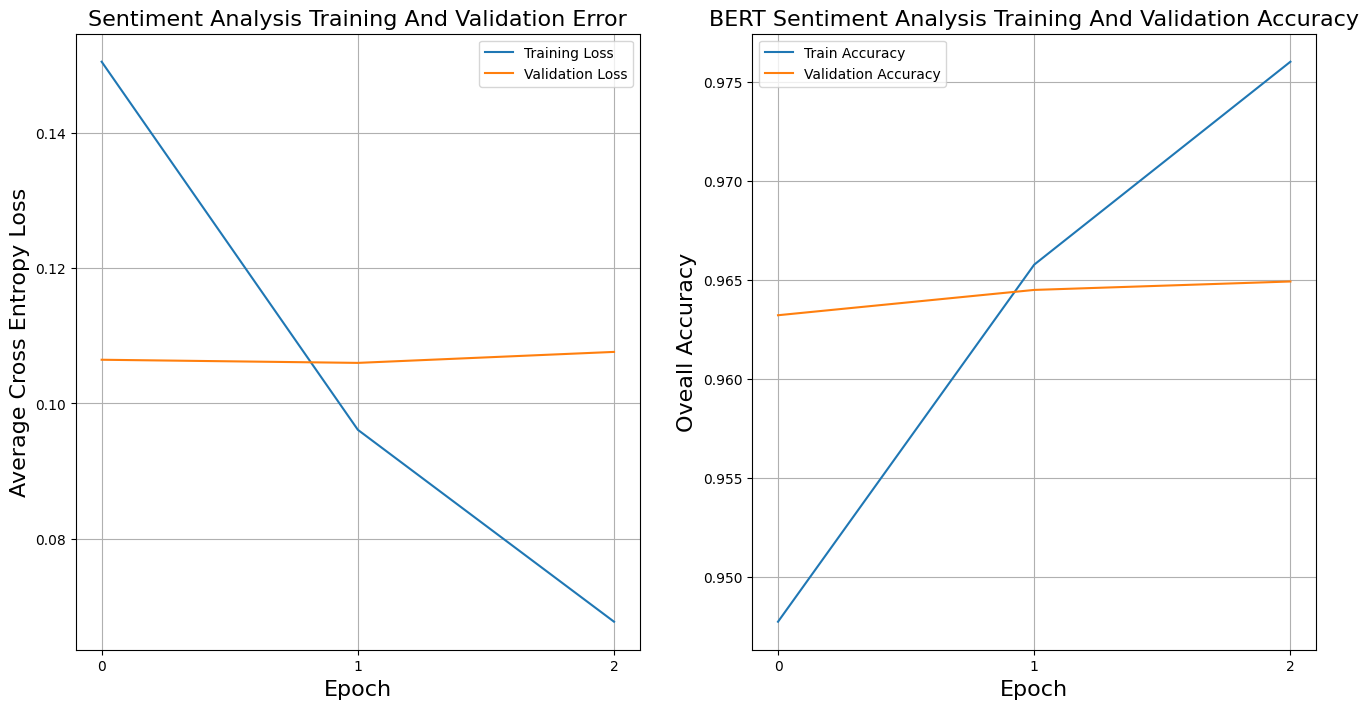

In [26]:
# Define sub plots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# plot train and validation loss

axs[0].plot(metrics["train loss"],
        label="Training Loss")
axs[0].plot(metrics["validation loss"],
        label="Validation Loss")

axs[0].set_title(f"Sentiment Analysis Training And Validation Error",
                 fontsize = 16)
axs[0].set_xlabel("Epoch",
                 fontsize = 16)
axs[0].set_ylabel("Average Cross Entropy Loss",
                  fontsize = 16)
axs[0].set_xticks(range(n_epochs))
axs[0].legend()
axs[0].grid()


# plot train and validation accuracy

axs[1].plot(metrics["train accuracy"],
        label="Train Accuracy")

axs[1].plot(metrics["validation accuracy"],
        label="Validation Accuracy")


axs[1].set_xlabel("Epoch",
                 fontsize = 16)

axs[1].set_ylabel("Oveall Accuracy",
                  fontsize = 16)

axs[1].set_xticks(range(n_epochs))

plt.title('BERT Sentiment Analysis Training And Validation Accuracy',
        fontsize = 16)

axs[1].legend()
axs[1].grid()

In [27]:
path = '/content/drive/MyDrive/Duke/Spring2024/LLM/FinalProject/'
model_save_name = 'BERT_YesNoPred_Tuned_20240502.pt'

torch.save(model.state_dict(), path + model_save_name)

### References
1. Jin, Qiao, et al. "Pubmedqa: A dataset for biomedical research question answering." arXiv preprint arXiv:1909.06146 (2019).